In [9]:
import torch
import matplotlib.pyplot as plt


In [10]:
from utils import integrate_evolution  # Import of the function used to integrate evolutions laws

def generate_data_with_latin(E, R0, h, F_imposed):
    """
    This function simulates the true model in order to generate the data need for the training.
    Input: 
        - E: Young modulus
        - R0: Initial elasticity limit
        - h: Hardening modulus
        - F_imposed: torch.tensor containing all the values of the imposed force at each time step.
    Output:
        - eps_total: total strain (torch.tensor containing the values at each time step)
        - eps_elastic: elastic strain (torch.tensor containing the values at each time step)
        - eps_plastic: plastic strain (torch.tensor containing the values at each time step)
        - sigma: stress (torch.tensor containing the values at each time step)
        - R: isotropic hardening variable (torch.tensor containing the values at each time step)
        - p: cumulated plastic strain (torch.tensor containing the values at each time step)
    """
    
    eps_plastic = torch.zeros_like(F_imposed)
    p, R = torch.zeros_like(F_imposed), torch.zeros_like(F_imposed)

    ## Iteration 0 (elastic initialisation)
    eps_elastic = F_imposed / E 
    eps_total = eps_plastic + eps_elastic


    relative_update = 1
    while relative_update > 1e-4:
        # Local step (integration of evolution laws)
        eps_plastic, eps_elastic, R, p = integrate_evolution(eps_total, eps_plastic, eps_elastic, R, p, R0, h, E)

        # Global step
        d_eps_elastic = (E * eps_elastic - F_imposed) / E
        relative_update = torch.max(torch.abs(d_eps_elastic[1:] / eps_elastic[1:]))
        eps_elastic -= d_eps_elastic
        eps_total = eps_plastic + eps_elastic
        sigma = E * eps_elastic

    return eps_total, eps_elastic, eps_plastic, sigma, R, p

In [11]:
E_true = 1 # Young modulus
R0_true = 0.5  # Initial elasticity limit
F_imposed = torch.linspace(0, 1, 100)

h_true = 1  # True value of the hardening modulus
eps_total_true, eps_elastic_true, eps_plastic_true, sigma_true, R_true, p_true = generate_data_with_latin(E_true, R0_true, h_true, F_imposed)

noise_level = 1e-4

mean = torch.abs(eps_total_true).mean()
noise = torch.normal(std=noise_level * mean * torch.ones_like(eps_total_true), mean=0)
eps_total_true_noisy = eps_total_true + noise


t = 1,   sigma_points = [0.8, 0.8001, 0.7999]
t = 1,   grad_mcre = [0.0, 0.0, 0.0]

######

t = 2,   sigma_points = [0.7999999999992724, 0.8001414213555097, 0.7998585786430351]
t = 2,   grad_mcre = [0.0, 0.0, 0.0]

######

t = 3,   sigma_points = [0.7999999999992724, 0.8001732050800293, 0.7998267949185155]
t = 3,   grad_mcre = [0.0, 0.0, 0.0]

######

t = 4,   sigma_points = [0.7999999999992724, 0.8001999999992724, 0.7997999999992724]
t = 4,   grad_mcre = [0.0, 0.0, 0.0]

######

t = 5,   sigma_points = [0.7999999999992724, 0.8002236067970223, 0.7997763932015225]
t = 5,   grad_mcre = [0.0, 0.0, 0.0]

######

t = 6,   sigma_points = [0.7999999999992724, 0.8002449489735507, 0.7997550510249941]
t = 6,   grad_mcre = [0.0, 0.0, 0.0]

######

t = 7,   sigma_points = [0.7999999999992724, 0.8002645751303789, 0.799735424868166]
t = 7,   grad_mcre = [0.0, 0.0, 0.0]

######

t = 8,   sigma_points = [0.7999999999992724, 0.800282842711747, 0.7997171572867978]
t = 8,   grad_mcre = [0.0, 0.0, 0.0]



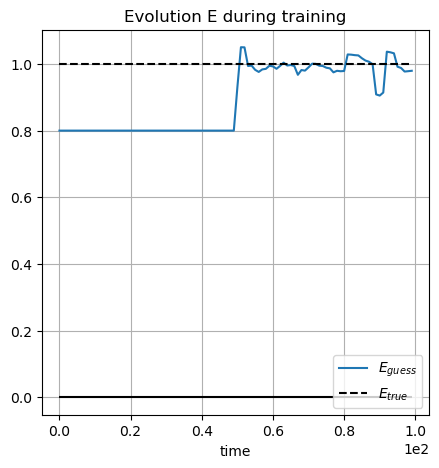

In [12]:


from utils import step_1_mcre_MDKF_evol, compute_grad_mcre_evolution_for_MDKF
from plot_utils import plot_evolution_E_KF

import math 

# Input of the MDKF framework

L = 1  # number of parameters to update (here hardening modulus)
alpha_KF = 1e-2
beta = 2 # because of normal distribution assumption
h_guess = 0.8
E = E_true
R0 = R0_true
C = 1e-4  # initial covariance on parameters
Q_p = C

alpha_mcre = 1e4
lambda_ = (alpha_KF **2) * (L+0) - L

# weight associated with sigma point
W_0_m = lambda_ / (L+lambda_)
W_1_m = 1 / (2*(L+lambda_))
W_2_m = 1 / (2*(L+lambda_))

W_0_c = W_0_m + 1 - alpha_KF**2 + beta
W_1_c = W_1_m
W_2_c = W_2_m
weight_m = [W_0_m, W_1_m, W_2_m]
weight_c = [W_0_c, W_1_c, W_2_c]

X_0 = h_guess
X_1 = h_guess + math.sqrt((L+lambda_)*C)
X_2 = h_guess - math.sqrt((L+lambda_)*C)
sigma_points = [X_0, X_1, X_2]

list_h_guess = [h_guess]

dict_sol_U = {'eps_total':0, 'eps_elastic':0, 'eps_plastic':0,'sigma':0,'R':0,'p':0}
dict_sol_V = {'eps_total':0,'eps_elastic':0,'eps_plastic':0,'sigma':0,'R':0,'p':0}
solution_t =  {'U':dict_sol_U, 'V':dict_sol_V}

for t in range(1, len(F_imposed)):
    # Calculationg sigma-points
    X_0 = h_guess
    X_1 = h_guess + math.sqrt((L+lambda_)*C)
    X_2 = h_guess - math.sqrt((L+lambda_)*C)
    sigma_points = [X_0, X_1, X_2]
    print(f'\n{t = },   {sigma_points = }')
    
    # Prediction of parameter vector and associated covariance matrices 
    sigma_points_minus = sigma_points
    h_t_minus = sum(i[0] * i[1] for i in zip(sigma_points_minus, weight_m))  # weighted mean of sigma points
    diff_sigma_points_E_t_minus = [sigma_points_minus[i] - h_t_minus for i in range(0, len(sigma_points_minus))]
    C_t_minus = sum((i[0]**2) * i[1] for i in zip(diff_sigma_points_E_t_minus, weight_c)) + Q_p  # weighted mean of sigma points
    
    
    # Sigma point propagation
    grad_mcre = []
    solution_t_minus_1 = solution_t.copy()
    
    for sigma_point in sigma_points_minus:
        
        solution_t_sigma_point = step_1_mcre_MDKF_evol(solution_t_minus_1, alpha_mcre, F_imposed[t], eps_total_true_noisy[t], E, R0, sigma_point)
        grad_mcre.append(compute_grad_mcre_evolution_for_MDKF(solution_t_sigma_point['U']['p'], solution_t_sigma_point['V']['p']))
        
        
    print(f'{t = },   {grad_mcre = }')
    # Prediction of observation and associated covariance matrices
    weighted_grad = sum(i[0] * i[1] for i in zip(grad_mcre, weight_m)) 
    diff_grad_weighted_grad =  [grad_mcre[i] - weighted_grad for i in range(0, len(grad_mcre))]
    CZZ = sum((i[0]**2) * i[1] for i in zip(diff_grad_weighted_grad, weight_c))  # weighted mean of sigma points
    CpZ = sum(i[0] * i[1] * i[2] for i in zip(diff_grad_weighted_grad, diff_sigma_points_E_t_minus, weight_c))  # weighted mean of sigma points
    
    # Correction 
    if CZZ!=0:
        K_t = CpZ/CZZ
    else:
        K_t = 0
    h_guess = h_t_minus - K_t * weighted_grad
    solution_t = step_1_mcre_MDKF_evol(solution_t_minus_1, alpha_mcre, F_imposed[t], eps_total_true_noisy[t], E, R0, h_guess)
    #print(f'{t = },   {CZZ = }')
    #print(f'{t = },   {CpZ = }')
    C = C_t_minus - K_t * CZZ * K_t
    list_h_guess.append(h_guess)
    #print(f'{t = },   {C = }')
    
    print('\n######')
    
    
plot_evolution_E_KF(list_h_guess, h_true)


